In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
from tbparse import SummaryReader
import torch
os.chdir('../')
print(os.getcwd())

/Users/gbemidebe/Documents/GitHub/knnGuidedDesign


In [3]:
from src.data.loader import load_vae_hp_params, load_gnn_hp_params
from src.viz.plotters import Parallel_Coordinates

In [4]:
log_vae_dir = "reports/VAE/hyper_search_logs/knnMoleculeVAE/version_1/"
vae_reader = SummaryReader(log_vae_dir, pivot=True)
vae_df = vae_reader.scalars

In [5]:
vae_params = ['enc_hidden_dim_1', 'enc_hidden_dim_2', 'dec_hidden_dim_1', 'dec_hidden_dim_2',
             'learning_rate', 'dropout', 'num_epochs', 'seed', 'batch_size', 'trn_loss', 'val_loss']

vae_ignore_list = ['input_dim', 'max_len', 'latent_dim', 'width_dim', 'height_dim', 'split_ratio']

vae_hpp_df = load_vae_hp_params(path="reports/VAE/hyper_search_logs/knnMoleculeVAE/version_*",
                             params=vae_params, ignore_list=vae_ignore_list)

Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_0
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_1
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_10
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_11
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_12
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_13
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_14
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_15
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_16
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_17
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_18
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_19
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_2
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_20
Processing reports/VAE/hyper_search_logs/knnMoleculeVAE/version_2

In [6]:
vae_cols = ['enc_hd_1', 'enc_hd_2', 'dec_hd_1', 'dec_hd_2', 'lr', 'dropout', 'num_epochs', 'seed', 'batch', 'trn_loss', 'val_loss']

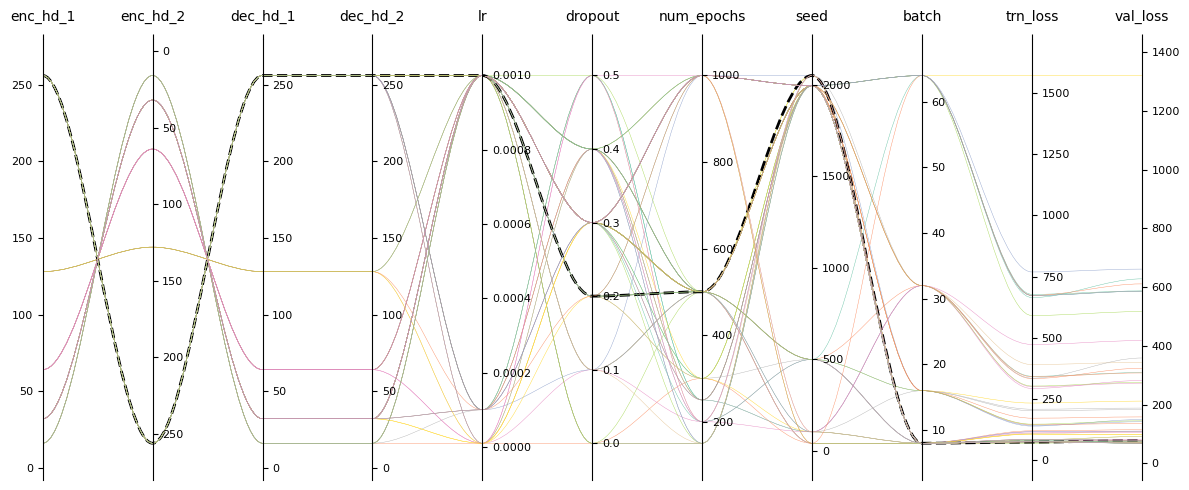

In [7]:
fig,ax = plt.subplots(figsize=(12,5))
pcd = Parallel_Coordinates(df=vae_hpp_df, cols=vae_cols, best_itr=50,ax=ax, wrap_label=False).plot()
plt.tight_layout()
plt.savefig("reports/pretrainVAE_hyperparams.png", dpi=600, facecolor='w', edgecolor='none',bbox_inches='tight')
plt.show()

# GNN

In [8]:
log_gnn_dir = "reports/GNN/hyper_search_logs/knnMoleculeGNN/version_100/"
gnnreader = SummaryReader(log_gnn_dir, pivot=True)
df_gnn = gnnreader.scalars

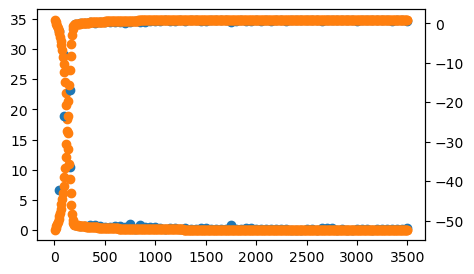

In [9]:
fig, axs = plt.subplots(figsize=(5, 3))
axs.scatter(df_gnn['step'], df_gnn['train_loss'], label='train_loss')
axs.scatter(df_gnn['step'], df_gnn['val_loss'], label='val_loss')
axs_ = axs.twinx()
axs_.scatter(df_gnn['step'], df_gnn['train_acc'], label='train_acc')
axs_.scatter(df_gnn['step'], df_gnn['val_acc'], label='val_acc')
plt.show()

In [10]:
gnn_params = ['hidden_fcn_dim', 'hidden_gcn_dim', 'learning_rate', 'n_fcn_layers',
             'n_gcn_layers', 'num_epochs', 'seed', 'seed', 'batch_size', 
          'trn_loss', 'val_loss', 'trn_acc', 'val_acc']

gnn_ignore_list = ['split', 'device']
gnn_hpp_df = load_gnn_hp_params(path="reports/GNN/hyper_search_logs/knnMoleculeGNN/version_*",
                             params=gnn_params, ignore_list=gnn_ignore_list)

Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_0
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_1
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_10
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_100
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_11
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_12
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_13
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_14
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_15
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_16
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_17
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_18
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_19
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_2
Processing reports/GNN/hyper_search_logs/knnMoleculeGNN/version_

In [11]:
gnn_cols = ['hd_fc', 'hd_gc', 'lr', 'n_fc', 'n_gc', 'num_epochs', 'seed', 'batch', 'trn_loss', 'val_loss', 'trn_acc', 'val_acc']

In [15]:
# find columns whose difference between gnn_hpp_df['trn_loss'] - gnn_hpp_df['val_loss'] is less than 0.1
# gnn_hpp_df[gnn_hpp_df['trn_loss'] < 0.01]
import numpy as np
difference = np.abs(gnn_hpp_df['trn_loss'] - gnn_hpp_df['val_loss'])
gnn_hpp_df[difference < 0.1]

,run,hidden_fcn_dim,hidden_gcn_dim,learning_rate,n_fcn_layers,n_gcn_layers,num_epochs,seed,batch_size,trn_loss,val_loss,trn_acc,val_acc
0,run_1,64,16,0.0010,4,1,200,1994,16,0.042582,0.141476,-1.702663,0.771850
3,run_4,256,64,0.0010,1,4,300,104,32,0.047711,0.115432,0.952191,0.837932
4,run_5,64,64,0.0010,4,2,200,1994,16,0.018160,0.104463,0.981754,0.832192
5,run_6,128,64,0.0010,4,4,200,1994,16,0.002653,0.099022,-0.781736,0.843557
11,run_12,128,16,0.0010,3,5,200,1994,16,0.013583,0.107134,0.802004,0.832629
14,run_15,32,256,0.0010,3,3,1000,2050,16,0.002398,0.091972,0.981783,0.857221
20,run_21,64,64,0.0010,4,1,300,104,16,0.004019,0.084810,0.994286,0.868764
21,run_22,64,64,0.0010,5,1,300,104,16,0.000957,0.099150,0.987741,0.846775
24,run_25,32,64,0.0010,3,5,300,104,32,0.070694,0.141721,0.800297,0.797971
27,run_28,64,64,0.0010,4,1,300,104,16,0.004019,0.084810,0.994286,0.868764


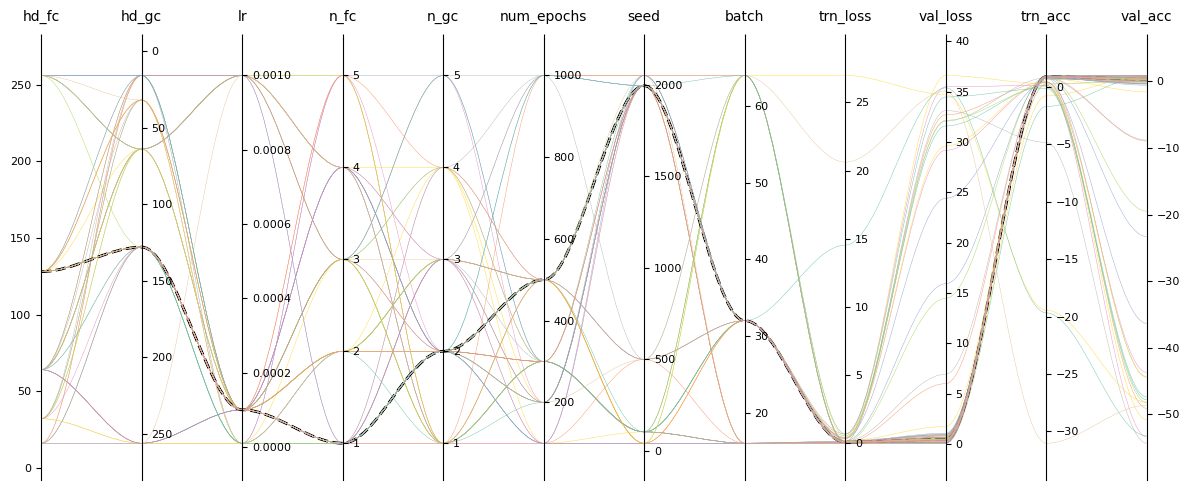

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
gnn_pc = Parallel_Coordinates(df=gnn_hpp_df, cols=gnn_cols, best_itr=50,ax=ax, wrap_label=False).plot()
plt.tight_layout()
plt.savefig("reports/pretrainGNN_hyperparams.png", dpi=600, facecolor='w', edgecolor='none',bbox_inches='tight')
plt.show()